# Offensive Language Detection in Social Media

Offensive language detection in social media refers to the process of identifying and flagging content that contains language or expressions that are considered inappropriate, disrespectful, harmful, or offensive to certain groups or individuals.

The goal of offensive language detection is to help maintain a respectful and safe online environment by automatically identifying and filtering out content that may violate community guidelines or terms of service on social media platforms. It's used by social media companies to moderate user-generated content, protect users from harassment or abuse, and prevent the spread of harmful or inappropriate content.

## The Task
After Elon Musk's acquisition of X, former Twitter, hate speech skyrocketed on the social media platform [[1]]. Given Mr. Musk's occasional difficulty in identifying offensive language, it may be beneficial to assist him by developing a model for offensive language detection.

Your task is to construct a model, train it using an annotated dataset, and determine whether any of the following tweets from the former President of the United States, Donald J. Trump, could be deemed offensive.

> I heard poorly rated @Morning_Joe speaks badly of me (don't watch anymore). Then how come low I.Q. Crazy Mika, along with Psycho Joe, came to Mar-a-Lago 3 nights in a row around New Year's Eve, and insisted on joining me. She was bleeding badly from a face-lift. I said no!

> .@ariannahuff is unattractive both inside and out. I fully understand why her former husband left her for a man- he made a good decision.

> Despite the constant negative press covfefe

> In the 1920's people were worried about global cooling--it never happened. Now it's global warming. Give me a break!

> Sorry losers and haters, but my I.Q. is one of the highest -and you all know it! Please don't feel so stupid or insecure,it's not your fault

> Did Crooked Hillary help disgusting (check out sex tape and past) Alicia M become a U.S. citizen so she could use her in the debate?

<img src="https://raw.githubusercontent.com/bbirke/ml-python/main/images/trump.jpg" alt="trump">


[1]: https://www.nytimes.com/interactive/2023/10/27/technology/twitter-x-elon-musk-anniversary.html

Download the data.

In [ ]:
!mkdir -p datasets/
!wget https://hyperion.bbirke.de/data/datasets/data_huang_devansh.csv -O datasets/data_huang_devansh.csv

--2024-03-09 07:04:42--  https://hyperion.bbirke.de/data/datasets/data_huang_devansh.csv
Resolving hyperion.bbirke.de (hyperion.bbirke.de)... 45.10.26.122
Connecting to hyperion.bbirke.de (hyperion.bbirke.de)|45.10.26.122|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 260468106 (248M) [text/csv]
Saving to: ‘datasets/data_huang_devansh.csv’

datasets/data_huang 100%[===================>] 248.40M  18.4MB/s    in 15s     

2024-03-09 07:04:57 (17.0 MB/s) - ‘datasets/data_huang_devansh.csv’ saved [260468106/260468106]



The data is stored as a `.csv` file and contains $2$ columns:

* **Content** = the tweet of user from the socal media plattform twitter.
* **Label** = class label of the tweet. $0$ - no offensive language $1$ - offensive language

## Hints

* Please note that there is no predefined train/test split in this dataset. You will need to create the splits manually, for instance, using the scikit-learn function [sklearn.model_selection.train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).

* Keep an eye on the distribution of class frequencies in your dataset. You can use a stratified sampling approach with the `stratifed` parameter in the `train_test_split` function.

* As we have an imbalanced dataset in regards to our class label distribution, we should penalize infrequent classes to prevent the model from being biased towards the majority class. One common approach to address this issue is by using class weighting. This technique helps ensuring that the neural network learns to generalize well across all classes, leading to more robust classification performance.\
You can apply it by using the scikit-learn function [sklearn.utils.class_weight.compute_class_weight](https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html), which creates a vector of inverse class frequencies as weights. The resulting `numpy.ndarray` can then be converted to `torch.tensor` (of `dtype=torch.float`) and then be passed as an argument during the instantiation of our loss object with the `weight` parameter.

* Accuracy can be a misleading metric in the context of imbalanced datasets because it doesn't consider the distribution of classes. In an imbalanced dataset, where one class is significantly more prevalent than others, a classifier can achieve high accuracy by simply predicting the majority class for every instance.\
For example, if you have a dataset where $95\%$ of the samples belong to class **A** and only $5\%$ belong to class **B**, a classifier that always predicts class **A** will achieve $95\%$ accuracy.\
Instead, metrics like precision, recall, and F1-Score are more informative in imbalanced datasets. Precision measures the proportion of true positive predictions among all positive predictions, while recall measures the proportion of true positives among all actual positives. The F1-Score is the harmonic mean of precision and recall, providing a balance between the two metrics.\
You can calculate the F1-Score by using the scikit-learn function [sklearn.metrics.f1_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score).


In [ ]:
import torch
from torch import nn

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

In [ ]:
df = pd.read_csv("datasets/data_huang_devansh.csv")
df.Label = df.Label.astype(int)
df.Content = df.Content.astype(str)

In [ ]:
df.head()

,Content,Label
0,`- This is not ``creative``. Those are the di...,0
1,` :: the term ``standard model`` is itself le...,0
2,"True or false, the situation as of March 200...",0
3,"Next, maybe you could work on being less cond...",0
4,This page will need disambiguation.,0


[Text(0.5, 0, ''), Text(0.5, 1.0, 'class distribution')]

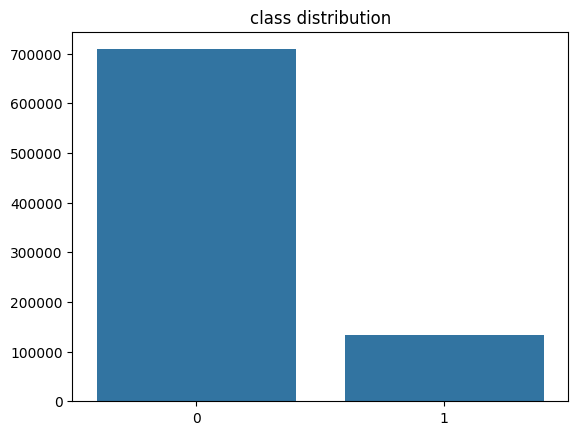

In [ ]:
df_counts = df['Label'].value_counts()
sns.barplot(x=df_counts.index, y=df_counts.values).set(xlabel=None, title='class distribution')

In [ ]:
val2label = {
    0: "Non-Offensive",
    1: "Offensive Language",
}

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
        df['Content'].to_list(),
        df['Label'].to_list(),
        test_size=0.2,
        random_state=42,
        stratify=df['Label'].to_list()
    )

In [ ]:
print(len(X_train))
print(len(X_test))

673868
168467


In [ ]:
weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)

In [ ]:
class OLDataset(Dataset):
    def __init__(self, texts, labels, transform=None, target_transform=None):
        self.transform = transform
        self.target_transform = target_transform
        self.labels = labels
        self.texts = texts

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        if self.transform:
            text = self.transform(text)
        if self.target_transform:
            label = self.target_transform(label)
        return text, label

In [ ]:
train_data = OLDataset(
        texts=X_train,
        labels=y_train
    )
test_data = OLDataset(
        texts=X_test,
        labels=y_test
    )

In [ ]:
examples = 10

for i in range(examples):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    text, label = train_data[sample_idx]
    print('Tweet:')
    print(text)
    print(f'Category: {val2label[label]}')
    print('-'*30 + '\n')

Tweet:
Boston's Jihadi Nest and Student Arm of the Muslim Brotherhood &#187; Joe For America http://t.co/4IfJwoeSDR via @RealJTP
Category: Non-Offensive
------------------------------

Tweet:
"Prostitution was the ONLY thing bringing tourists to Rockford. 7 years ago the streets were packed with people coming for the prostitutes. The restaurants\xa0 were packed, the bars were packed, the hotels were packed and all of the businesses were making money and bringing in the revenue for the city. Now, look at what you have. ALL of the businesses are closed, there is nobody coming to town and the only thing packed now are the jails, with nasty, 50 year old hookers, and a city that has the nations highest poverty level. Putting 50 silly sculptures in the park draws no tourists. Right or wrong, prostitution was the key to Rockford's success. Your mayor destroyed your city so he could build a city of jails."
Category: Non-Offensive
------------------------------

Tweet:
Omg Kat and Andre are coo

In [ ]:
tokenizer = get_tokenizer('basic_english')

In [ ]:
tokenizer("This is a simple Test.")

['this', 'is', 'a', 'simple', 'test', '.']

In [ ]:
def yield_tokens(dataset):
    for idx in range(len(dataset)):
        text, _ = dataset[idx]
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(train_data), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

In [ ]:
tokens = tokenizer("This is a simple test.")
indices = vocab(tokens)
reversed_tokens = vocab.lookup_tokens(indices)

print(tokens)
print(indices)
print(reversed_tokens)

['this', 'is', 'a', 'simple', 'test', '.']
[17, 11, 9, 739, 863, 1]
['this', 'is', 'a', 'simple', 'test', '.']


In [ ]:
text_processor = lambda x: vocab(tokenizer(x))
label_processor = lambda x: int(x)

def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for _text, _label in batch:
        label_list.append(label_processor(_label))
        processed_text = torch.tensor(text_processor(_text), dtype=torch.int64)
        text_list.append(processed_text)
        offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return text_list, label_list, offsets

In [ ]:
batch_size = 32
epochs = 5
learning_rate = 1e-3

In [ ]:
train_dataloader = DataLoader(
        train_data,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=collate_batch,
    )

test_dataloader = DataLoader(
        test_data,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=collate_batch,
    )

In [ ]:
class OLModel(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super().__init__()
        self.embedding = nn.EmbeddingBag(
                num_embeddings=vocab_size,
                embedding_dim=embed_dim,
                sparse=False
            )
        self.linear_stack = nn.Sequential(
            nn.Linear(in_features=embed_dim, out_features=16),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=16, out_features=8),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(8, 2)
        )

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.linear_stack(embedded)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
model = OLModel(vocab_size=len(vocab), embed_dim=25).to(device)

In [ ]:
texts, labels, offsets = next(iter(train_dataloader))

texts = texts.to(device)
offsets = offsets.to(device)
logits = model(texts, offsets)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)

print(f"Predicted class: {y_pred}")

Predicted class: tensor([0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0,
        0, 0, 1, 1, 0, 0, 0, 0], device='cuda:0')


In [ ]:
loss_fn = nn.CrossEntropyLoss(weight=torch.tensor(weights, dtype=torch.float).to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y, offset) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)
        offset = offset.to(device)
        pred = model(X, offset)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 1000 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn, best_result):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    predicted_labels = []
    actual_labels = []

    with torch.no_grad():
        for X, y, offset in dataloader:
            X = X.to(device)
            y = y.to(device)
            offset = offset.to(device)
            pred = model(X, offset)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            predicted_labels.extend(pred.argmax(1).cpu().tolist())
            actual_labels.extend(y.cpu().tolist())

    test_loss /= num_batches
    correct /= size
    f1 = f1_score(actual_labels, predicted_labels, average='weighted')
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, F1-Score: {(100*f1):>0.1f}%, Avg loss: {test_loss:>8f}")
    if f1 > best_result:
        print("New highscore! Saving model...\n")
        torch.save(model.state_dict(), 'best-model-parameters.pt')
        return f1
    print()
    return best_result

In [ ]:
best_result = 0.0
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    best_result = test_loop(test_dataloader, model, loss_fn, best_result)
print("Done!")

Epoch 1
-------------------------------
loss: 0.696075  [ 2561/673868]
loss: 0.489760  [33956/673868]
loss: 0.543763  [66771/673868]
loss: 0.566569  [98654/673868]
loss: 0.473390  [129686/673868]
loss: 0.411042  [161480/673868]
loss: 0.523867  [194795/673868]
loss: 0.280381  [226590/673868]
loss: 0.400740  [257883/673868]
loss: 0.613156  [289579/673868]
loss: 0.848252  [321658/673868]
loss: 0.392098  [354233/673868]
loss: 0.314656  [385513/673868]
loss: 0.205607  [418524/673868]
loss: 0.172751  [449633/673868]
loss: 0.416725  [483158/673868]
loss: 0.399246  [514266/673868]
loss: 0.375795  [545777/673868]
loss: 0.222083  [577287/673868]
loss: 0.371009  [609967/673868]
loss: 0.267988  [641724/673868]
loss: 0.168233  [674858/673868]
Test Error: 
 Accuracy: 85.4%, F1-Score: 86.6%, Avg loss: 0.353887
New highscore! Saving model...

Epoch 2
-------------------------------
loss: 0.276656  [ 3304/673868]
loss: 0.245146  [33652/673868]
loss: 0.163781  [66160/673868]
loss: 0.264070  [97510/67386

In [ ]:
model.load_state_dict(torch.load("best-model-parameters.pt"))

<All keys matched successfully>

In [ ]:
model.eval()

examples = 10

for i in range(examples):
    sample_idx = torch.randint(len(test_data), size=(1,)).item()
    text, actual_label = test_data[sample_idx]
    text_tensor, actual_label_tensor, offset_tensor = collate_batch([(text, actual_label)])
    text_tensor = text_tensor.to(device)
    offset_tensor = offset_tensor.to(device)
    logits = model(text_tensor, offset_tensor)
    pred_probab = nn.Softmax(dim=1)(logits)
    y_pred = pred_probab.argmax(1)
    y_prob = pred_probab.max()
    print('Tweet:')
    print(text)
    print(f'Predicted Category: \"{val2label[y_pred.item()]}\" with p={y_prob.item():.3f}')
    print(f'Actual Category: \"{val2label[actual_label]}\"')
    print('-'*30 + '\n')

Tweet:
 ::Excellent reply. Thoroughly researched and brilliantly argued. A fine retort to those who take the uncompromising view that 'NSA has superpowers, and noone is safe cause noone is half as awesome'. Too bad most people probably won't take the time to read it all.
Predicted Category: "Non-Offensive" with p=0.994
Actual Category: "Non-Offensive"
------------------------------

Tweet:
Controlling codes in languages 

I have written a series of articles about a theme which may have a connection with supernatural affects on human beings, as well as material world. The theme may not be a continuation of any other view point on parapsycholgy. If anyone is interested they can find the first chapter here: . The rest are in the same forum pages.
Predicted Category: "Non-Offensive" with p=1.000
Actual Category: "Non-Offensive"
------------------------------

Tweet:
@BasicMountain it's hard for me to find good marvel schwag. i've got a nice print from target (lol), but DC sadly does better

<Axes: >

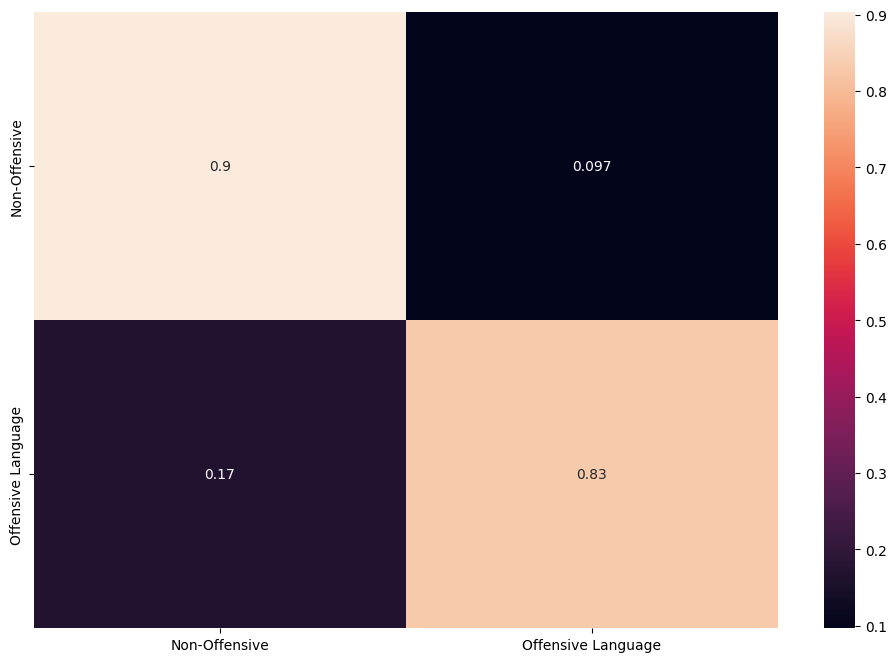

In [ ]:
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    # iterate over test data
    for X, y, offset in test_dataloader:

            X = X.to(device)
            y = y.to(device)
            offset = offset.to(device)
            output = model(X, offset)

            output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
            y_pred.extend(output)

            labels = y.data.cpu().numpy()
            y_true.extend(labels)

cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [val2label[i] for i in range(2)],
                     columns = [val2label[i] for i in range(2)])
plt.figure(figsize = (12,8))
sns.heatmap(df_cm, annot=True)

In [ ]:
model.eval()

trump_tweets = [
    "I heard poorly rated @Morning_Joe speaks badly of me (don't watch anymore). Then how come low I.Q. Crazy Mika, along with Psycho Joe, came to Mar-a-Lago 3 nights in a row around New Year's Eve, and insisted on joining me. She was bleeding badly from a face-lift. I said no!",
    ".@ariannahuff is unattractive both inside and out. I fully understand why her former husband left her for a man- he made a good decision.",
    "Despite the constant negative press covfefe",
    "In the 1920's people were worried about global cooling--it never happened. Now it's global warming. Give me a break!",
    "Sorry losers and haters, but my I.Q. is one of the highest -and you all know it! Please don't feel so stupid or insecure,it's not your fault",
    "Did Crooked Hillary help disgusting (check out sex tape and past) Alicia M become a U.S. citizen so she could use her in the debate?"
]

for tweet in trump_tweets:
    text_tensor, actual_label_tensor, offset_tensor = collate_batch([(tweet, 0)])
    text_tensor = text_tensor.to(device)
    offset_tensor = offset_tensor.to(device)
    logits = model(text_tensor, offset_tensor)
    pred_probab = nn.Softmax(dim=1)(logits)
    y_pred = pred_probab.argmax(1)
    y_prob = pred_probab.max()
    print('Tweet:')
    print(tweet)
    print(f'Predicted Category: \"{val2label[y_pred.item()]}\" with p={y_prob.item():.3f}')
    print('-'*30 + '\n')

Tweet:
I heard poorly rated @Morning_Joe speaks badly of me (don't watch anymore). Then how come low I.Q. Crazy Mika, along with Psycho Joe, came to Mar-a-Lago 3 nights in a row around New Year's Eve, and insisted on joining me. She was bleeding badly from a face-lift. I said no!
Predicted Category: "Non-Offensive" with p=0.772
------------------------------

Tweet:
.@ariannahuff is unattractive both inside and out. I fully understand why her former husband left her for a man- he made a good decision.
Predicted Category: "Non-Offensive" with p=0.614
------------------------------

Tweet:
Despite the constant negative press covfefe
Predicted Category: "Non-Offensive" with p=0.996
------------------------------

Tweet:
In the 1920's people were worried about global cooling--it never happened. Now it's global warming. Give me a break!
Predicted Category: "Non-Offensive" with p=0.987
------------------------------

Tweet:
Sorry losers and haters, but my I.Q. is one of the highest -and you 